In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [31]:
data = pd.read_csv('AirPassengers.csv')

In [32]:
data['Date'] = pd.to_datetime(data['Month'])

In [33]:
data = data[['Date', '#Passengers']]

In [34]:
data = data.rename(columns={'#Passengers':'Passengers'})

In [35]:
# create 12 month moving average
data['MA12'] = data['Passengers'].rolling(12).mean()

In [36]:
data.head()

,Date,Passengers,MA12
0,1949-01-01,112,NaN
1,1949-02-01,118,NaN
2,1949-03-01,132,NaN
3,1949-04-01,129,NaN
4,1949-05-01,121,NaN


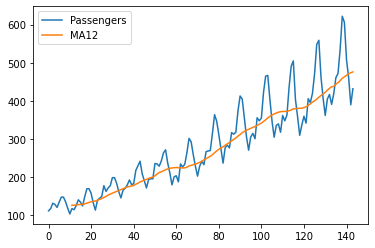

In [37]:
data[['Passengers','MA12']].plot();

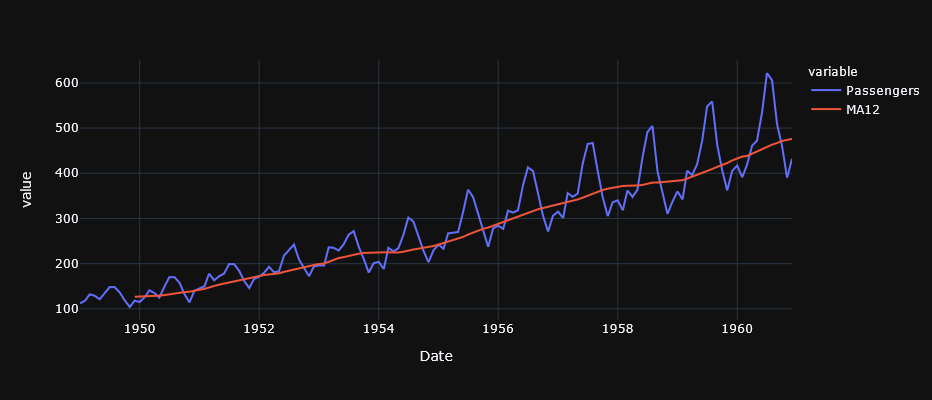

In [48]:
# plot the data and MA
import plotly.express as px
fig = px.line(data, x="Date", y=["Passengers", "MA12"], template = 'plotly_dark', width=800, height=400)
fig.show()

In [50]:
# extract month and year from dates
data['Month'] = [i.month for i in data['Date']]
data['Year'] = [i.year for i in data['Date']]

In [51]:
data = data.drop(['Date'], axis=1)

In [52]:
# create a sequence of numbers
data['Series'] = np.arange(1,len(data)+1)

In [53]:
# drop unnecessary columns and re-arrange
data.drop(['MA12'], axis=1, inplace=True)
data = data[['Series', 'Year', 'Month', 'Passengers']] 

In [54]:
data.head()

,Series,Year,Month,Passengers
0,1,1949,1,112
1,2,1949,2,118
2,3,1949,3,132
3,4,1949,4,129
4,5,1949,5,121


In [55]:
# split data into train-test set
train = data[data['Year'] < 1960]
test = data[data['Year'] >= 1960]

In [56]:
# check shape
train.shape, test.shape

((132, 4), (12, 4))

In [1]:
# import the regression module
from pycaret.regression import *

In [19]:
# initialize setup
s = setup(data = data, train_size = 0.9, data_split_shuffle = False, target = 'Passengers', 
          fold_strategy = 'timeseries', numeric_features = ['Year', 'Series'], 
          fold = 3, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Passengers
2,Original Data,"(144, 4)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(129, 13)"


In [20]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lar,Least Angle Regression,22.6114,988.0323,28.7963,0.5720,0.0886,0.0747,0.0400
lr,Linear Regression,22.6115,988.0467,28.7965,0.5720,0.0886,0.0747,2.9000
br,Bayesian Ridge,22.6496,992.1366,29.0256,0.5719,0.0892,0.0746,0.0300
huber,Huber Regressor,22.6595,963.8611,28.3289,0.6040,0.0886,0.0753,0.0500
ridge,Ridge Regression,23.0726,1042.3648,30.3204,0.5390,0.0938,0.0757,2.3167
lasso,Lasso Regression,37.5172,2310.4838,46.2540,0.1035,0.1474,0.1229,2.4933
en,Elastic Net,39.3793,2482.0555,48.4846,-0.0620,0.1556,0.1326,0.0300
omp,Orthogonal Matching Pursuit,42.6327,2860.3718,52.4882,-0.4203,0.1695,0.1484,0.0300
gbr,Gradient Boosting Regressor,53.5292,4513.3893,64.0021,-0.6681,0.2110,0.1626,0.0567
et,Extra Trees Regressor,55.1023,4606.0201,64.3820,-0.7094,0.2159,0.1699,0.2767


In [57]:
#Performance on the test data
prediction_holdout = predict_model(best);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,28.1806,1113.5649,33.3701,0.8036,0.0741,0.0651


In [58]:
# generate predictions on the original dataset
predictions = predict_model(best, data=data)

In [59]:
# add a date column in the dataset
predictions['Date'] = pd.date_range(start='1949-01-01', end = '1960-12-01', freq = 'MS')

In [61]:
predictions.head()

,Series,Year,Month,Passengers,Label,Date
0,1,1949,1,112,110.758506,1949-01-01
1,2,1949,2,118,109.773909,1949-02-01
2,3,1949,3,132,128.112373,1949-03-01
3,4,1949,4,129,123.941234,1949-04-01
4,5,1949,5,121,124.873990,1949-05-01


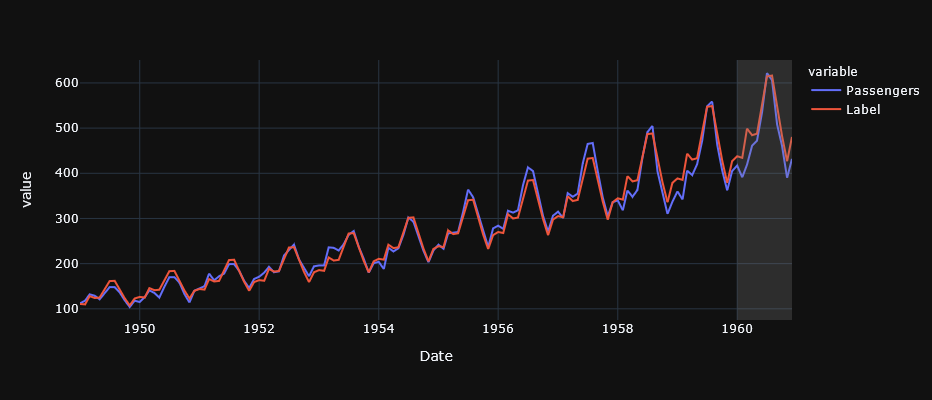

In [66]:
# line plot
fig = px.line(predictions, x='Date', y=["Passengers", "Label"], template = 'plotly_dark', width=800, height=400)


# add a vertical rectange for test-set separation
fig.add_vrect(x0="1960-01-01", x1="1960-12-01", fillcolor="grey", opacity=0.25, line_width=0)
fig.show()

In [67]:
final_best = finalize_model(best)

In [68]:
# Prediction of passengers for 5 years in the future  (1961 to 1966)

# Creating dataframe including month, year and Series columns
future_dates = pd.date_range(start = '1961-01-01', end = '1966-01-01', freq = 'MS')


future_df = pd.DataFrame()

future_df['Month'] = [i.month for i in future_dates]
future_df['Year'] = [i.year for i in future_dates]    
future_df['Series'] = np.arange(145,(145+len(future_dates)))
future_df.head()

,Month,Year,Series
0,1,1961,145
1,2,1961,146
2,3,1961,147
3,4,1961,148
4,5,1961,149


In [87]:
# generate predictions in the future dataset using final best model
future_pred = predict_model(final_best, data=future_df)

In [93]:
# Creating a dataset with original passengers data and future predictions 
concat_df = pd.concat([data ,future_pred], axis=0)

concat_df['Date'] = pd.date_range(start='1949-01-01', end = '1966-01-01', freq = 'MS')

In [94]:
concat_df

,Series,Year,Month,Passengers,Date,Label
0,1,1949,1,112.0,1949-01-01,NaN
1,2,1949,2,118.0,1949-02-01,NaN
2,3,1949,3,132.0,1949-03-01,NaN
3,4,1949,4,129.0,1949-04-01,NaN
4,5,1949,5,121.0,1949-05-01,NaN
...,...,...,...,...,...,...
56,201,1965,9,NaN,1965-09-01,885.205768
57,202,1965,10,NaN,1965-10-01,794.820723
58,203,1965,11,NaN,1965-11-01,710.261720
59,204,1965,12,NaN,1965-12-01,787.512947


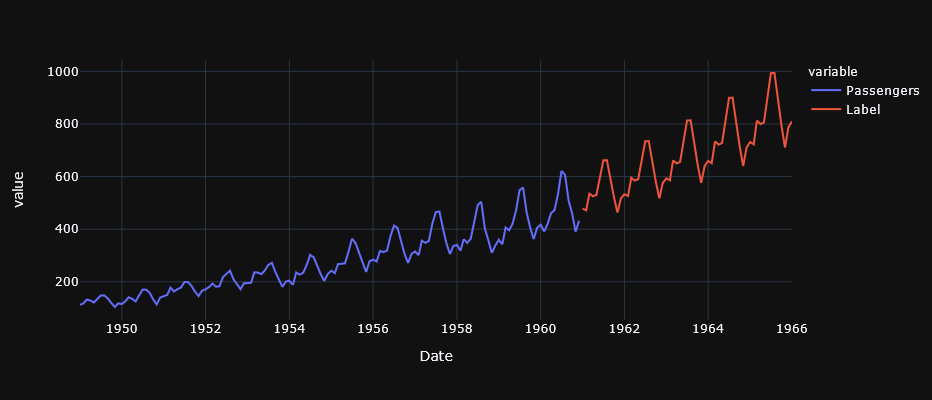

In [100]:
fig = px.line(concat_df, x=concat_df['Date'], y=["Passengers", "Label"], 
              template = 'plotly_dark', width=800, height=400,
              labels = {"Passengers":"Original_Data", "Label":"Future_Predictions"})
fig.show()